# Homework 1 - Supervised Deep Learning
# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

>**Daniele Mellino, student ID 2013373** <br>
>M.Sc. Physics of Data<br>
>Department of Physics and Astronomy








# Regression task

### Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

### Dataset

In [1]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler,Subset, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import transforms

import imageio

from scipy.stats import loguniform

from tqdm import tqdm



In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-02-05 15:11:55--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-02-05 15:11:56 (45.0 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-02-05 15:11:56--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

How to load the data:

In [3]:
train_df = pd.read_csv('regression_dataset/train_data.csv')

How to get a specific sample:

In [4]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label'] 

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

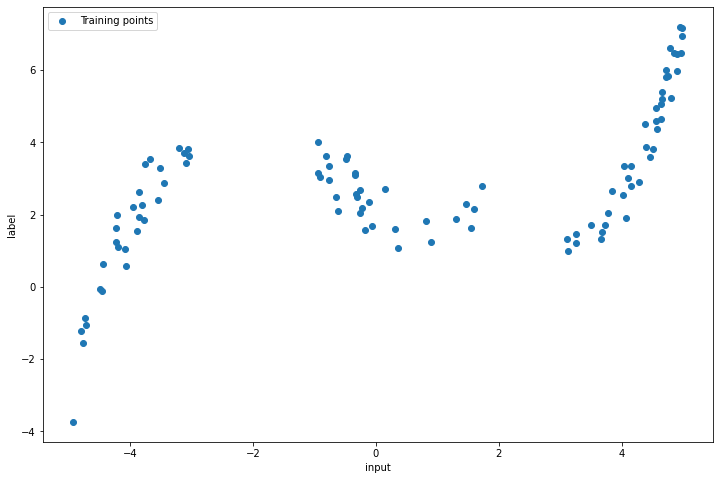

In [5]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

### Dataset preparation

In [13]:
class Csv_df_Dataset(Dataset):

    def __init__(self, csv_file='', transform=None,df_bool=False, df_name=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        if df_bool == False:
            self.df = pd.read_csv(csv_file)
        else: self.df = df_name


    def __len__(self):
        # The length of the dataset is simply the length of the  dataframe
        return len(self.df)

    def __getitem__(self, idx):
        # Our sample is the element row of the dataframe
        x=self.df.iloc[idx]['input']
        y=self.df.iloc[idx]['label'] 

        sample = [x,y]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [14]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [15]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = Csv_df_Dataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = Csv_df_Dataset('regression_dataset/test_data.csv', transform=composed_transform)


In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(42)

Training device: cuda


### Regression class

In [45]:
# define simple neural network of 2 layer:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No , dp=0):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        dp - Dropout rate for both layer
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2 )
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()
        self.drop=nn.Dropout(p=dp)   
        
    def forward(self, x, additional_out=False):
        x1 = self.act(self.fc1(x))
        x1 = self.drop(x1)
        x2 = self.act(self.fc2(x1))
        x2 = self.drop(x2)
        xf = self.out(x2)

        return xf

    #here I decide to insert directly in the class the train_step and the validation one

    def train_step(self,train_loader, optimizer, loss_func, device):
        """
        basic training step
        """
        train_loss= []
        self.train() # Training mode (e.g. enable dropout)
        for sample_batched in train_loader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            # Forward pass
            out = self.forward(x_batch)
            # Compute loss 
            loss = loss_func(out, label_batch)
            # Backpropagation
            self.zero_grad()
            loss.backward()
            # Update the weights
            optimizer.step()
            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        return train_loss
    
    def validation_step(self, val_loader, loss_func, device):
        """
        basic validation step
        """
        val_loss = []
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_loader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
                # Forward pass
                out = self.forward(x_batch)
                # Compute loss
                loss = loss_func(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

        return val_loss

    def fit(self, train_loader, val_loader, optimizer, loss_func, params):
        """
        Training procedure 
        Args:
            self (Net)        : Neural network model
            train_loader      : Dataloader of train set
            val_loader        : Dataloader of validation set
            loss_fn           : Torch loss function
            optimizer         : Torch optimizer
            params (dict)     : Contains all the parameters
                                num_epochs
                                device
        """
        train_loss_log = []
        val_loss_log = []
        for epoch in tqdm(range( params['num_epochs'])):
            ### TRAIN
            train_loss = self.train_step(train_loader, optimizer, loss_func,  params['device'])
            # Save average train loss
            train_loss = np.mean(train_loss)
            #if epoch%10==0: print(f"AVERAGE TRAIN LOSS: {train_loss}")
            train_loss_log.append(train_loss)
            ### VALIDATION
            val_loss = self.validation_step(val_loader, loss_func,  params['device'])
            # Save average validation loss
            val_loss = np.mean(val_loss)
            #if epoch%10==0: print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)
            
        return train_loss_log, val_loss_log
    
    def predict(self, dataloader, device):
        self.eval()
        predictions = []
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                # Forward pass
                out = self.forward(x_batch)
                out = out.cpu().numpy()
                predictions.append(out)

        return np.array( predictions )

       
    def test(self, test_loader, loss_func, device):
        """
        Basic Test, return accuracy 
        """
        accuracy = []
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in tqdm(test_loader):
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1][0].to(device)
                # Forward pass
                out = self.forward(x_batch)
                loss = loss_func(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                # Save val loss for this batch
                accuracy.append( loss_batch.mean() )

        return np.array(accuracy).mean()
    
    # common methods :
    def save(self, path):
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        self.load_state_dict( torch.load(path) )
        
    def restart(self):
        self.__init__()
        
    


### Cross validation

In [12]:
def divide_folds(dataset, num_folds=4 ):
    num_data = len(dataset)
    len_folds = num_data//num_folds
    folds_idx = np.array([ [j for j in range(i*len_folds,(i+1)*len_folds ) ] 
                 for i in range(num_folds)  ])
    folds = [ Subset(dataset, folds_idx[i]) for i in range(num_folds)]
    return folds


def random_sample(parameters):
    sampled = {}
    for i in parameters.keys():
        sampled[i] = np.random.choice( parameters[i] )
    return sampled


In [11]:
def CrossValidate(parameters, dataset, num_folds=4, N=5,bs=20):
    # Array for the outputs
    params = []
    train_loss_log = []
    val_loss_log = []
    # Loss function
    loss = nn.MSELoss() 
    folds = divide_folds(dataset, num_folds=num_folds)
    for i in range(N):
        # Random parameter selection
        par_t = random_sample(parameters)
        params.append(par_t)
        train_loss_kf=np.zeros( (num_folds, par_t['num_epochs']) )
        val_loss_kf=np.zeros( (num_folds, par_t['num_epochs']) )
        for j, f in enumerate(folds):
            # prepare dataset
            val_load = DataLoader(f, batch_size=bs, shuffle=False, num_workers=0 )
            train_set = folds[:j]+folds[j+1:] #take out folds j
            train_set = ConcatDataset( train_set )
            train_load = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=0 )
            
            ## Random parameter selection
            #par_t = random_sample(parameters)
            #params.append(par_t)

            # Initialization of the net
            Ni, Nh1, Nh2, No = 1, par_t['Nh'], 2*par_t['Nh'], 1
            Rnet = Net(Ni, Nh1, Nh2, No, par_t['dropout']).to(par_t['device'])
            # Initialization of the optimizer
            if par_t['optimizer']=='adam':
                opt = optim.Adam(Rnet.parameters(), lr=par_t['learning_rate'], 
                                 weight_decay=par_t['regularization'])
            elif par_t['optimizer']=='sgd':
                opt = optim.SGD(Rnet.parameters(), lr=par_t['learning_rate'], momentum=0.9,
                               weight_decay=par_t['regularization'])
            elif par_t['optimizer']=='Rmsprop':
                opt = optim.RMSprop(Rnet.parameters(), lr=par_t['learning_rate'],
                                    weight_decay=par_t['regularization'])
        
            
                
            # Training & validation
            train_loss, val_loss = Rnet.fit(train_load, val_load, opt, loss, par_t)
            
            # Storing train/loss validation
            train_loss_kf[j,:] = train_loss 
            val_loss_kf[j,:]   = val_loss 
        train_loss_log.append(np.mean(np.array(train_loss_kf), axis=0))
        val_loss_log.append(  np.mean(np.array(val_loss_kf), axis=0))
    return params, train_loss_log, val_loss_log


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

parameters = {  "device"           : [device],
            "dropout"          : np.random.uniform(0, 0.5, 100),
            "num_epochs"       : [150, 200, 250, 300, 350],
            "learning_rate"    : loguniform.rvs(5e-5, 1e-2, size=1000),
            "optimizer"        : ['sgd', 'adam', 'Rmsprop'],
            "Nh"               : [40, 50, 60, 75, 85],
            "regularization"   : loguniform.rvs(1e-5, 1e-3, size=1000)
            
         }


Training device: cuda


## Run2

In [29]:
params_tried, train_l, val_l = CrossValidate(parameters, train_dataset, num_folds=4, N=100)

Network initialized


100%|██████████| 200/200 [00:08<00:00, 22.70it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 22.57it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 22.46it/s]


Network initialized


100%|██████████| 200/200 [00:09<00:00, 22.16it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.12it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 22.96it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 22.29it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 22.57it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.91it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.08it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.87it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.85it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.12it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.11it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.83it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.12it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.20it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.44it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.88it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.87it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.09it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.05it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.43it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.68it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.41it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.63it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.38it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.90it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.78it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.54it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.59it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.27it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.73it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.70it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.92it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.46it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.05it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.16it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.36it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.12it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.87it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.24it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.01it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.11it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.63it/s]


Network initialized


100%|██████████| 200/200 [00:07<00:00, 25.01it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.81it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.20it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.10it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.22it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.94it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.02it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.68it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.50it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.69it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 25.00it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.92it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.04it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.00it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.24it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.71it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.11it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.33it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.93it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.39it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.08it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.35it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.66it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.94it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.24it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.62it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.34it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.50it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.68it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.70it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 25.00it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.03it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.56it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.69it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.51it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.83it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.51it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.47it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.03it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.92it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.08it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.97it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.93it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.07it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.92it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.91it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.53it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.59it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.58it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.41it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.18it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.88it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.27it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.44it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.65it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.69it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.56it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.83it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.03it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.05it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.90it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.80it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.25it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.90it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.31it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.77it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.07it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.24it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.16it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.81it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.05it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.08it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.18it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.13it/s]


Network initialized


100%|██████████| 350/350 [00:16<00:00, 21.07it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.25it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.69it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.80it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.53it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.27it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.49it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.33it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.20it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.25it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.24it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.25it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.77it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.44it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.46it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.78it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.84it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.38it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.73it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 26.22it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.88it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.80it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.21it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.84it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.00it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.01it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.49it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.44it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.01it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.27it/s]


Network initialized


100%|██████████| 300/300 [00:11<00:00, 25.23it/s]


Network initialized


100%|██████████| 300/300 [00:11<00:00, 25.26it/s]


Network initialized


100%|██████████| 300/300 [00:11<00:00, 25.28it/s]


Network initialized


100%|██████████| 300/300 [00:11<00:00, 25.16it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.68it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.36it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.81it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.98it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.59it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.61it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.36it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.29it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.30it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.27it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.10it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.30it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.94it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 26.23it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.88it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.74it/s]


Network initialized


100%|██████████| 200/200 [00:07<00:00, 25.72it/s]


Network initialized


100%|██████████| 200/200 [00:07<00:00, 25.87it/s]


Network initialized


100%|██████████| 200/200 [00:07<00:00, 25.87it/s]


Network initialized


100%|██████████| 200/200 [00:07<00:00, 25.67it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.31it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.12it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.99it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.96it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.85it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.22it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.20it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.93it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.83it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.82it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.90it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 26.06it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.12it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.62it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.97it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.08it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.48it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.64it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.77it/s]


Network initialized


100%|██████████| 250/250 [00:09<00:00, 25.86it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.11it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.09it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.90it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.82it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.31it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.80it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.46it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.14it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.63it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.03it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.33it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.40it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.97it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.99it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.77it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.24it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.96it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.94it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.92it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.49it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.44it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.93it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.01it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.44it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.92it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.25it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.14it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.99it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.95it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.88it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.14it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.14it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.51it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.70it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.67it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.67it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.11it/s]


Network initialized


100%|██████████| 250/250 [00:11<00:00, 22.70it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 22.90it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.36it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.82it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.80it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.73it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.85it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.10it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.16it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.46it/s]


Network initialized


100%|██████████| 150/150 [00:05<00:00, 25.54it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.63it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.17it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 22.54it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 22.85it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.63it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.01it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.66it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.69it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.13it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.04it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.90it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.07it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.89it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.17it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.27it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.98it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.45it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.91it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.72it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.41it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.43it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.82it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.21it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.24it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.96it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.51it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.10it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.79it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.19it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.33it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.25it/s]


Network initialized


100%|██████████| 350/350 [00:13<00:00, 25.40it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.61it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.63it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.86it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.15it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.64it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.57it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.65it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.67it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.59it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.97it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.95it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.09it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.60it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.05it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.53it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.47it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.43it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.02it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.16it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 24.12it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.54it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.65it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.67it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.52it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.58it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.55it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.63it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.49it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.41it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.48it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.36it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.08it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.48it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.18it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.37it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.54it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.24it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.43it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.25it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.87it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.28it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.51it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.42it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.21it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.98it/s]


Network initialized


100%|██████████| 200/200 [00:07<00:00, 25.17it/s]


Network initialized


100%|██████████| 200/200 [00:07<00:00, 25.71it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.77it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.72it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.70it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.65it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 24.50it/s]


Network initialized


100%|██████████| 200/200 [00:07<00:00, 25.02it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.45it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.49it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.02it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.38it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.50it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.54it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.76it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.31it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.65it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.65it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.49it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.78it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 23.13it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 22.98it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.02it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.13it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.27it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.38it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.45it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.09it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.57it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.08it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.34it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.15it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.95it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.89it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.24it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.36it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.29it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.14it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.09it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.28it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.27it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.70it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.38it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.01it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.41it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.94it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.56it/s]


Network initialized


100%|██████████| 200/200 [00:08<00:00, 24.47it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.37it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.58it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.89it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.92it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.19it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 24.24it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.82it/s]


Network initialized


100%|██████████| 150/150 [00:06<00:00, 23.84it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.32it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.14it/s]


Network initialized


100%|██████████| 350/350 [00:15<00:00, 23.15it/s]


Network initialized


100%|██████████| 350/350 [00:14<00:00, 23.35it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 24.04it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.83it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.96it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.70it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 22.92it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 22.95it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.75it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.50it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.16it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.25it/s]


Network initialized


100%|██████████| 300/300 [00:13<00:00, 22.89it/s]


Network initialized


100%|██████████| 300/300 [00:12<00:00, 23.27it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.01it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.49it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 23.25it/s]


Network initialized


100%|██████████| 250/250 [00:10<00:00, 22.77it/s]


<Figure size 432x288 with 0 Axes>

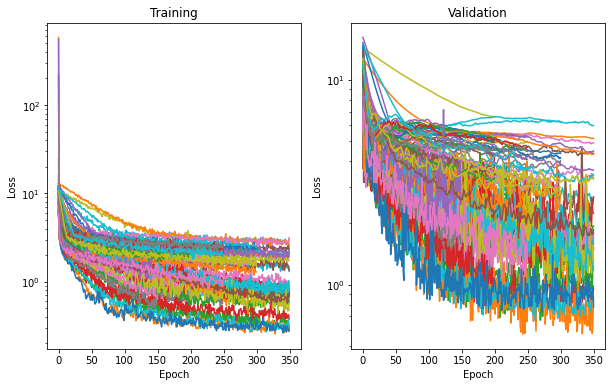

In [30]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10,6))
for i, train in enumerate(train_l):
    ax[0].semilogy(train)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training')

for i, val in enumerate(val_l):
    ax[1].semilogy(val)
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Validation')
    
plt.show()

In [31]:
avg_val_loss = [np.min(vl) for vl in val_l] 
best_net = params_tried[np.argmin(avg_val_loss)]
print('Best network parameters are :', best_net)


Best network parameters are : {'device': device(type='cuda'), 'dropout': 0.014401528700709543, 'num_epochs': 350, 'learning_rate': 0.0029172805760198407, 'optimizer': 'adam', 'Nh': 75, 'regularization': 0.0005495969903163338}


In [32]:
avg_val_loss = [np.min(vl[75:]) for vl in val_l] 
best_net = params_tried[np.argmin(avg_val_loss)]
print('Best network parameters are :', best_net)

Best network parameters are : {'device': device(type='cuda'), 'dropout': 0.014401528700709543, 'num_epochs': 350, 'learning_rate': 0.0029172805760198407, 'optimizer': 'adam', 'Nh': 75, 'regularization': 0.0005495969903163338}


In [34]:

best_net = {'device': device, 'dropout': 0.014401528700709543, 'num_epochs': 350, 'learning_rate': 0.0029172805760198407, 'optimizer': 'adam', 'Nh': 75, 'regularization': 0.0005495969903163338}


Network initialized


100%|██████████| 400/400 [00:33<00:00, 11.77it/s]


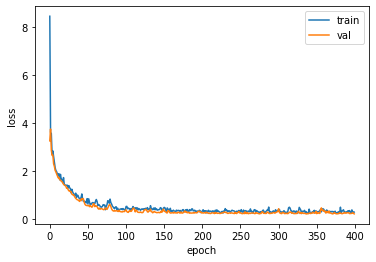

In [49]:
train_load = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0 )
val_load = train_load
loss = nn.MSELoss() 
# Best parameter selection
par_t = best_net
#print(par_t)
par_t['num_epochs']=400

# Initialization of the best net
Ni, Nh1, Nh2, No = 1, par_t['Nh'], 2*par_t['Nh'], 1
BRnet = Net(Ni, Nh1, Nh2, No, par_t['dropout']).to(par_t['device'])
# Initialization of the optimizer
if par_t['optimizer']=='adam':
    opt = optim.Adam(BRnet.parameters(), lr=par_t['learning_rate'], 
                     weight_decay=par_t['regularization'])
elif par_t['optimizer']=='sgd':
    opt = optim.SGD(BRnet.parameters(), lr=par_t['learning_rate'], momentum=0.9,
                   weight_decay=par_t['regularization'])
elif par_t['optimizer']=='Rmsprop':
    opt = optim.RMSprop(BRnet.parameters(), lr=par_t['learning_rate'],
                        weight_decay=par_t['regularization'])
        

# Training & validation
train_loss, val_loss = BRnet.fit(train_load, val_load, opt, loss, par_t)

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [55]:
n = 1000
x = np.hstack((np.linspace(-5,5, n).reshape(n,1), np.ones(n).reshape(n,1)))
x_data = pd.DataFrame( x.reshape(n,2), columns=['input', 'label'] )
x = Csv_df_Dataset(df_name = x_data,df_bool = True,  transform=composed_transform)
x = DataLoader(x, batch_size=20, shuffle=False, num_workers=0 )

pred = BRnet.predict(x, par_t['device'])#.flatten()



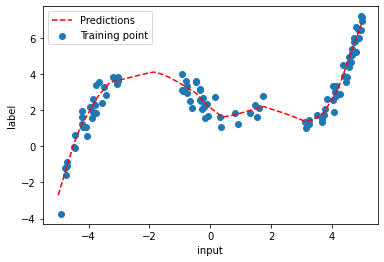

In [56]:
data = pd.read_csv( "regression_dataset/train_data.csv" )
plt.scatter(data['input'], data['label'], label='Training point')
plt.plot(x_data['input'], pred.flatten(), 'r--', label='Predictions')
plt.legend()
plt.ylabel('label')
plt.xlabel('input')
plt.show()



In [57]:
loss = nn.MSELoss() 
loss_test = BRnet.test(test_dataset, loss, best_net['device'])
print('Loss on test set:', loss_test)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:00<00:00, 1021.03it/s]

Loss on test set: 0.10117423


In [58]:
n = 1000
x = np.hstack((np.linspace(-5,5, n).reshape(n,1), np.ones(n).reshape(n,1)))
x_data = pd.DataFrame( x.reshape(n,2), columns=['input', 'label'] )
x = Csv_df_Dataset(df_name=x_data,df_bool=True,transform=composed_transform)
x = DataLoader(x, batch_size=20, shuffle=False, num_workers=0 )

pred = BRnet.predict(x, best_net['device'])#.flatten()

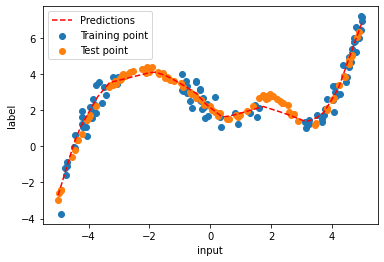

In [59]:
test_set = pd.read_csv('regression_dataset/test_data.csv')
plt.scatter(data['input'], data['label'], label='Training point')
plt.scatter(test_set['input'], test_set['label'], label='Test point')
plt.plot(x_data['input'], pred.flatten(), 'r--', label='Predictions')
plt.legend()
plt.ylabel('label')
plt.xlabel('input')
plt.show()


### Visualization of weight histograms, activation profiles and receptive fields2

In [60]:
h1_w = BRnet.fc1.weight.detach().cpu().numpy()
h2_w = BRnet.fc2.weight.detach().cpu().numpy()
out_w = BRnet.out.weight.detach().cpu().numpy()

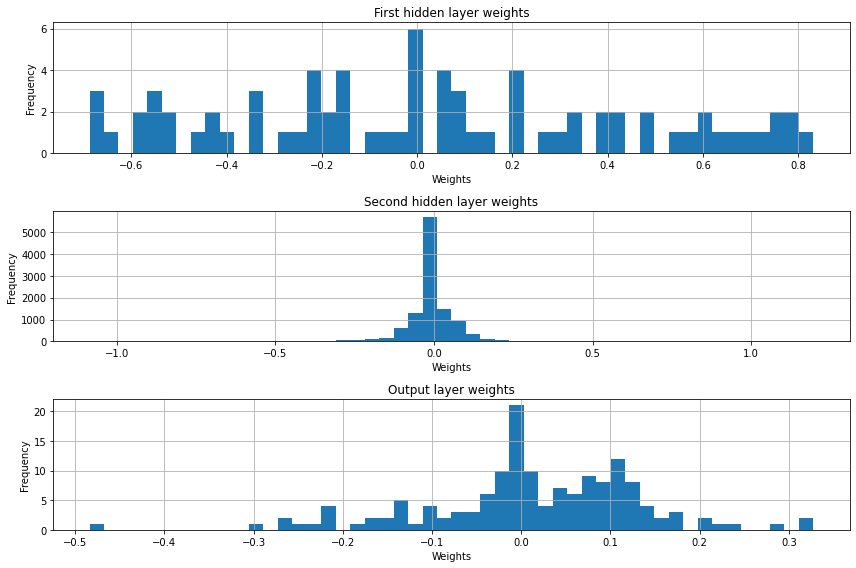

In [61]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w, 50)
axs[0].set_title('First hidden layer weights')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
axs[2].set_ylabel('Frequency')
axs[2].set_xlabel('Weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [62]:
# activation profiles
def get_activation(layer, input, output):
    global activation
    activation = F.relu(output)

def get_activation2(layer, input, output):
    global activation2
    activation2 = F.relu(output)

### Register hook  
hook_handle = BRnet.fc1.register_forward_hook(get_activation )
hook_handle2= BRnet.fc2.register_forward_hook(get_activation2)

### Analyze activations
net = BRnet.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-4]).float().to(device)
    y1 = net(x1)
    z1 = activation
    d1 = activation2
    x2 = torch.tensor([-2]).float().to(device)
    y2 = net(x2)
    z2 = activation
    d2 = activation2
    x3 = torch.tensor([0]).float().to(device)
    y3 = net(x3)
    z3 = activation
    d3 = activation2
    x4 = torch.tensor([2.5]).float().to(device)
    y4 = net(x4)
    z4 = activation
    d4 = activation2

### Remove hook
hook_handle.remove()
hook_handle2.remove()

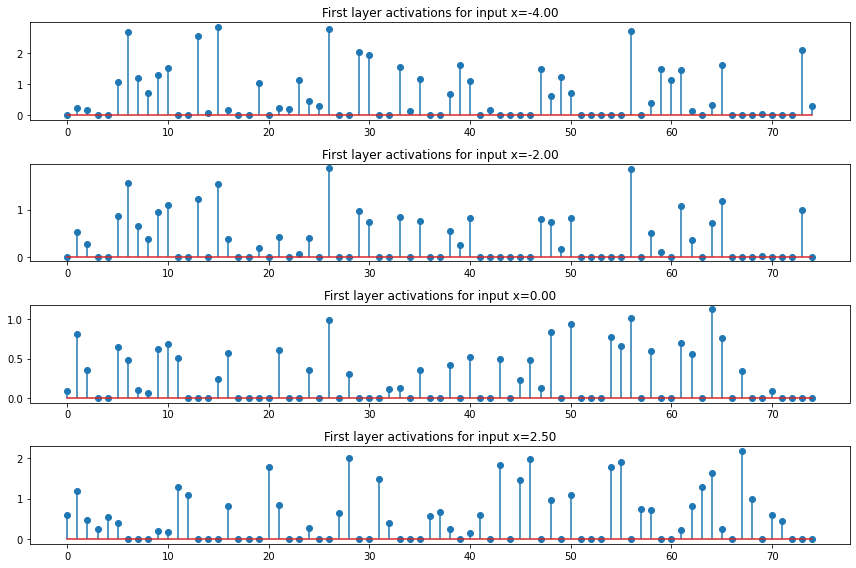

In [63]:

### Plot activations
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('First layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('First layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('First layer activations for input x=%.2f' % x3)
axs[3].stem(z4.cpu().numpy(), use_line_collection=True)
axs[3].set_title('First layer activations for input x=%.2f' % x4)
plt.tight_layout()
plt.show()

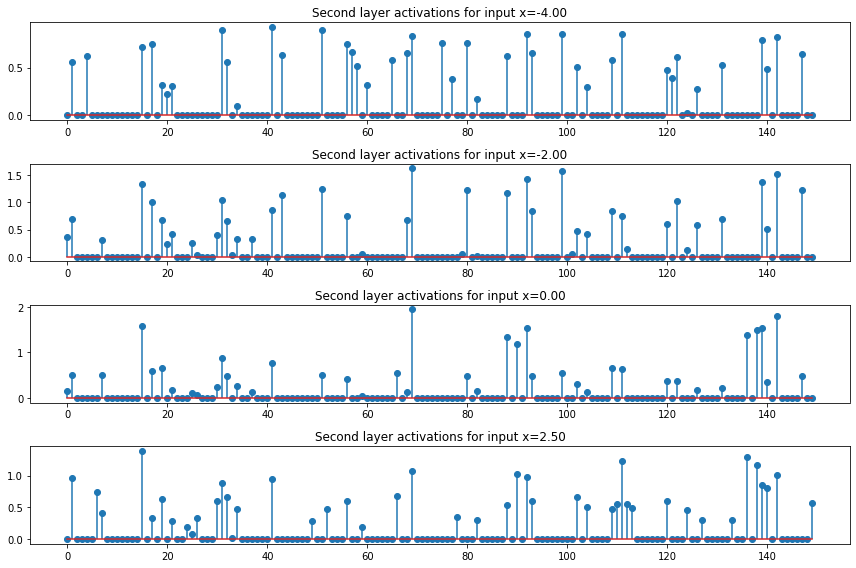

In [64]:
### Plot activations
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].stem(d1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Second layer activations for input x=%.2f' % x1)
axs[1].stem(d2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Second layer activations for input x=%.2f' % x2)
axs[2].stem(d3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Second layer activations for input x=%.2f' % x3)
axs[3].stem(d4.cpu().numpy(), use_line_collection=True)
axs[3].set_title('Second layer activations for input x=%.2f' % x4)
plt.tight_layout()
plt.show()